In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense

## I . Discover the environment

In [ ]:
import gym

In [ ]:
env = gym.make('MountainCar-v0')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (2,)
Number of actions:  3


## II . Model

In [ ]:
def DeepQNetwork(input, actions):
    """Actor (Policy) Model."""
    """Initialize parameters and build model.
        Params
        ======
            Input (int): Dimension of states
            actions (int): Dimension of actions
        """
    model = Sequential()
    model.add(Dense(64, input_dim=input, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(actions, activation=None))

    model.compile(optimizer='adam', loss='mse')
    return model

## III . Agent

In [ ]:
class Agent:
    def __init__(self,actions,input,discount_factor,epsilon):
      """Initialize an Agent object.
        
        Params
        ======
            actions (int): dimension of actions
            input (int): dimension of actions
            discount_factor (int): The discount factor
            epsilon (int): Epsilon value


        """
      self.action_space = [i for i in range(actions)]
      self.discount_factor = discount_factor
      self.epsilon = epsilon

      # Q-Network
      self.q_net = DeepQNetwork(input,actions)
      self.q_target_net = DeepQNetwork(input,actions)

      # Initialize time step (for updating every UPDATE_EVERY steps)
      self.t_step = 0

      # Replay memory
      self.buffer = ReplayBuffer(1000000, input)
        

    def step(self, state, action, reward, new_state, done):
        # Save experience in replay memory
        self.buffer.add(state, action, reward, new_state, done)

    def act(self, state):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
        """
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state = np.array([state])
            actions = self.q_net(state)
            action = tf.math.argmax(actions, axis=1).numpy()[0]

        return action

    def update(self):
        # Update value parameters using given batch of experience 
        if self.buffer.current_size >= 64:
          self.q_target_net.set_weights(self.q_net.get_weights())

          state_batch, action_batch, reward_batch, new_state_batch, done_batch = self.buffer.sample()

          q_predicted = self.q_net(state_batch)
          q_next = self.q_target_net(new_state_batch)
          q_max_next = tf.math.reduce_max(q_next, axis=1, keepdims=True).numpy()
          q_target = np.copy(q_predicted)
          
          for i in range(64):
              target_q_val = reward_batch[i]
              if not done_batch[i]:
                  target_q_val = target_q_val +  self.discount_factor * q_max_next[i]
              q_target[i, action_batch[i]] = target_q_val
          self.q_net.train_on_batch(state_batch, q_target)
          if self.epsilon > 0.01:
            self.epsilon = self.epsilon - 0.001
          else:
            self.epsilon = 0.01
          
          self.t_step = self.t_step + 1

    

## IV . Reply Buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, size, input_shape):
        """Initialize a ReplayBuffer object.
        Params
        ======
            size (int): dimension of actions
            size (int): maximum size of buffer
            input_shape (int): Dimension of states
        """

        self.size = size
        # current length of the buffer
        self.current_size = 0

        self.state = np.zeros((self.size, input_shape), dtype=np.float32)
        self.action = np.zeros(self.size, dtype=np.int32)
        self.reward = np.zeros(self.size, dtype=np.float32)
        self.next_state = np.zeros((self.size, input_shape), dtype=np.float32)
        self.done = np.zeros(self.size, dtype=np.bool_)

    def add(self, state, action, reward, new_state, done):
        """Add a new experience to memory."""
        i = self.current_size + 1 
        self.state[i] = state
        self.action[i] = action
        self.reward[i] = reward
        self.next_state[i] = new_state
        self.done[i] = done
        self.current_size = self.current_size + 1

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        max_buffer = min(self.current_size, self.size)
        batch = np.random.choice(max_buffer, 64, replace=False)
        state_batch = self.state[batch]
        action_batch = self.action[batch]
        reward_batch = self.reward[batch]
        new_state_batch = self.next_state[batch]
        done_batch = self.done[batch]

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch

## IV . Training

In [ ]:
env = gym.make("MountainCar-v0")
dqn_agent = Agent(actions=3,input=2,discount_factor=0.99,epsilon=1.0)

In [ ]:
class train_agent:
  def __init__(self,goal,env):
    """Train the agent.
        Params
        ======
            env: The openAIgym environment
            goal (float): The wanted average score
        """
    self.goal = goal
    self.env = env
    self.scores = []
    self.avg_scores = []

  def train(self):
      ep = 0
      avg = 0
      # Train the agent while it didn't reach the goal
      while avg <= self.goal:
          done = False
          score = 0.0
          state = self.env.reset()
          while not done:
              action = dqn_agent.act(state)
              new_state, reward, done, _ = self.env.step(action)
              score = score + reward
              dqn_agent.step(state, action, reward, new_state, done)
              state = new_state
              dqn_agent.update()
          self.scores.append(score)
          avg_score = np.mean(self.scores[-100:])
          self.avg_scores.append(avg_score)
          print("Episode "+ str(ep)+  "\t score : " + str(score) + "\t Eps : " + str(dqn_agent.epsilon) + "\t Average : " + str(avg_score) )
          avg = avg_score
          ep = ep + 1
          dqn_agent.q_net.save(f'model.h5')
    
  def plotting(self):
      # Plot the results ( score and average score )
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(self.scores)), self.scores)
        plt.ylabel('Score')
        plt.xlabel('Episodes')
        plt.show()

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(self.avg_scores)), self.avg_scores)
        plt.ylabel('Average Score')
        plt.xlabel('Episodes')
        plt.show()



        

In [ ]:
trained_agent = train_agent(100,env)
trained_agent.train()

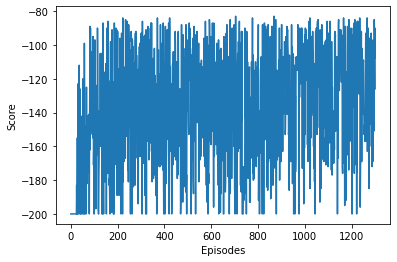

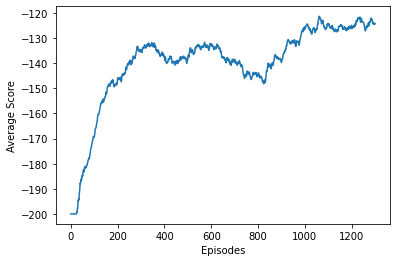

<Figure size 432x288 with 0 Axes>

In [ ]:
trained_agent.plotting()

In [ ]:
def test(env,num_episodes):
        dqn_agent.q_net.load_weights('model.h5')
        scores, avg_scores = [], []
        score = 0.0
        for i in range(num_episodes):
            state = env.reset()
            done = False
            episode_score = 0.0
            while not done:
                env.render()
                action = dqn_agent.act(state)
                new_state, reward, done, _ = env.step(action)
                episode_score = episode_score + reward
                state = new_state
            print('a')
            score = score + episode_score
            scores.append(episode_score)
            episodes.append(i)
            avg_score = np.mean(scores[-100:])
            avg_scores.append(avg_score)

         #fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(avg_scores)), avg_scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
        env.close()

In [ ]:
test(env, 1200)